In [1]:
import torch
def tensor_repr(x):
    tmp = f"{x.type()}"
    tmp +=  "[" + ','.join([str(s) for s in x.shape]) + "]"
    if x.dim() == 0:
        tmp += f", {x.item()}"
    return tmp

torch.Tensor.__repr__ = tensor_repr

x = torch.randn(2, 3, 480, 640)

In [2]:
from torchvision.models.segmentation._utils import _SimpleSegmentationModel


class SmallDeepLab(_SimpleSegmentationModel):
    def forward(self, x):
        features = self.backbone(x)
        # print("features :", features)
        x = features["out"]
        return features["res2"], self.classifier(x)

    
from torchvision.models.resnet import resnet50, resnet101
from torchvision.models._utils import IntermediateLayerGetter
from torchvision.models.utils import load_state_dict_from_url
from torchvision.models.segmentation.deeplabv3 import DeepLabHead
from torchvision.models.segmentation.fcn import FCNHead


net = SmallDeepLab(
    backbone=IntermediateLayerGetter(
        resnet101(pretrained=True, replace_stride_with_dilation=[False, True, True]),
        return_layers={'layer2':'res2', 'layer4': 'out'}
    ),
    classifier=DeepLabHead(2048, 21),
    aux_classifier = FCNHead(1024, 21)
)

state_dict = load_state_dict_from_url('https://download.pytorch.org/models/deeplabv3_resnet101_coco-586e9e4e.pth', progress=True)
net.load_state_dict(state_dict)
net.eval()
print("Done")

Done


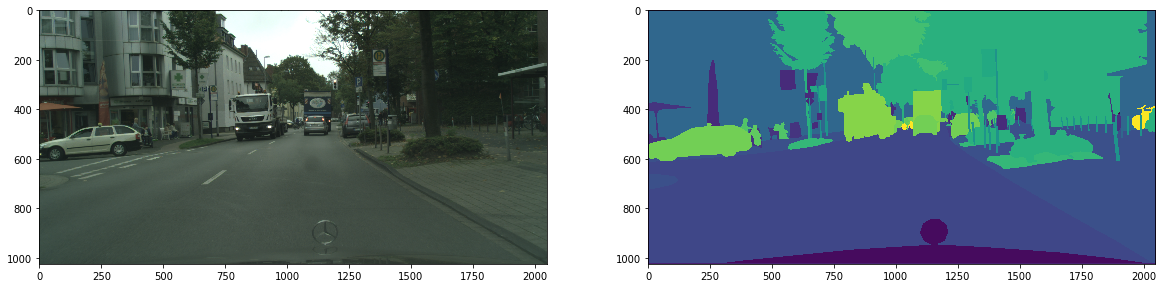

In [3]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt


filename = "/data2/DW/point-semantic/cityscapes/gtFine/val/munster/munster_000007_000019_gtFine"

img_path = f"{filename.replace('gtFine', 'leftImg8bit')}.png"
# img_path= "dog.jpg"
label_path = f"{filename}_labelIds.png"

input_pil = Image.open(img_path).convert("RGB")
label_npy = np.array(Image.open(label_path))

fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(input_pil)
ax[1].imshow(label_npy)

In [4]:
from torchvision import transforms
import torch

input_pil = input_pil.resize((2048, 1024))
preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
input_ = preprocess(input_pil)
label = torch.from_numpy(label_npy)

img = input_.unsqueeze(0) # create a mini-batch as expected by the model
img, label

(torch.FloatTensor[1,3,1024,2048], torch.ByteTensor[1024,2048])

In [5]:
with torch.no_grad():
    res2, out = net(img)
    
res2, out

(torch.FloatTensor[1,512,128,256], torch.FloatTensor[1,21,128,256])

<Figure size 432x288 with 0 Axes>

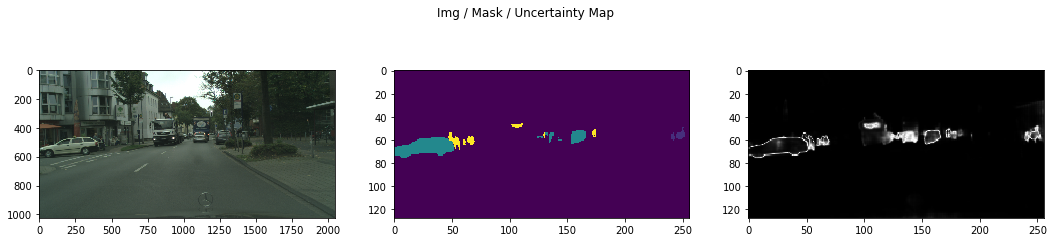

In [6]:
import matplotlib.pyplot as plt


with torch.no_grad():
    plt.figure()
    fig, ax = plt.subplots(1, 3, figsize=(18, 4))
    fig.suptitle("Img / Mask / Uncertainty Map")
    # softmax for normalize
    pred = out.softmax(1).argmax(1).float()
    
    """
    In Paper,
    To measure prediction uncertainty
    we use the same strategy during training and inference:
    the difference between the most confident
    and second most confident class probabilities
    """
    v, i = out.softmax(1).sort(1, descending=True)
    # uncertainty = (v[:, -1, :, :] - v[:, -2, :, :]) <= 0.5
    uncertainty = - (v[:, 0, :, :] - v[:, 1, :, :])
    
    ax[0].imshow(input_pil)
    ax[1].imshow(pred[0].numpy())
    ax[2].imshow(uncertainty[0].numpy(), cmap="gray")
    plt.show()

In [7]:
def plot(img, title, targets=None, s=0.5):
    if targets is None:
        plt.figure()
        plt.title(title)
        plt.imshow(img, cmap="gray")
        return

    fig, ax = plt.subplots(1, len(targets), figsize=(30*len(targets), 15))
    if len(targets) == 1:
        ax = [ax]
    fig.suptitle(title, fontsize=60)
    
    def scatter(ax_, p, c, s):
        if len(p) == 0:
            return
        H, W = img.shape[-2:]
        # p = p[0].numpy()  # Remove Batch
        y_axis = p[0, :, 0].numpy()
        x_axis = p[0, :, 1].numpy()
        ax_.scatter(y_axis, x_axis, c=c, s=s)

    for i, (ax_title, points) in enumerate(targets.items()): 
        ax[i].set_title(ax_title)
        ax[i].imshow(img)
        scatter(ax[i], points, "red", s)
        # scatter(ax[i], c_p, "yellow", s)


import torch
import torch.nn.functional as F


def point_sample(input, point_coords, **kwargs):
    """
    From Dectron2
    
    A wrapper around :function:`torch.nn.functional.grid_sample` to support 3D point_coords tensors.
    Unlike :function:`torch.nn.functional.grid_sample` it assumes `point_coords` to lie inside
    [0, 1] x [0, 1] square.

    Args:
        input (Tensor): A tensor of shape (N, C, H, W) that contains features map on a H x W grid.
        point_coords (Tensor): A tensor of shape (N, P, 2) or (N, Hgrid, Wgrid, 2) that contains
        [0, 1] x [0, 1] normalized point coordinates.

    Returns:
        output (Tensor): A tensor of shape (N, C, P) or (N, C, Hgrid, Wgrid) that contains
            features for points in `point_coords`. The features are obtained via bilinear
            interplation from `input` the same way as :function:`torch.nn.functional.grid_sample`.
    """
    add_dim = False
    if point_coords.dim() == 3:
        add_dim = True
        point_coords = point_coords.unsqueeze(2)
        
    # [0, 1] -> [-1, 1]
    output = F.grid_sample(input, 2.0 * point_coords - 1.0, **kwargs)
    if add_dim:
        output = output.squeeze(3)
    return output


@torch.no_grad()
def sampling_points(mask, N, k=3, beta=0.75, training=True):
    """
    Follows 3.1. Point Selection for Inference and Training

    In Train:, `The sampling strategy selects N points on a feature map to train on.`

    In Inference, `then selects the N most uncertain points`

    Args:
        mask(Tensor): [B, C, H, W]
        N(int): `During training we sample as many points as there are on a stride 16 feature map of the input`
        k(int): Over generation multiplier
        beta(float): ratio of importance points
        training(bool): flag

    Return:
        selected_point(Tensor) : flattened indexing points [B, num_points]
    """
    assert mask.dim() == 4, "Dim must be N(Batch)CHW"
    print("Mask :", mask.shape, " num_points :", N)
    device = mask.device
    B, _, H, W = mask.shape
    # Official Comment : point_features.py#92
    # It is crucial to calculate uncertanty based on the sampled prediction value for the points.
    # Calculating uncertainties of the coarse predictions first and sampling them for points leads
    # to worse results. To illustrate the difference: a sampled point between two coarse predictions
    # with -1 and 1 logits has 0 logit prediction and therefore 0 uncertainty value, however, if one
    # calculates uncertainties for the coarse predictions first (-1 and -1) and sampe it for the
    # center point, they will get -1 unceratinty.
            
    over_generation = torch.rand(B, k * N, 2, device=device)
    over_generation_map = point_sample(mask, over_generation, align_corners=False)    
    print("Over gen coord:", over_generation, " map :", over_generation_map)
    
    
    uncertainty_map = -1 * (over_generation_map[:, 0] - over_generation_map[:, 1])
    print("Uncertainty :", uncertainty_map)
    
    v, idx = uncertainty_map.topk(int(beta * N), -1)
    print("Idx :", idx)
    
    shift = (k * N) * torch.arange(B, dtype=torch.long, device=device)
    print("Shift :", shift)
    
    idx += shift[:, None]
    
    importance = over_generation.view(-1, 2)[idx.view(-1), :].view(B, int(beta * N), 2)
    coverage = torch.rand(B, N - int(beta * N), 2, device=device)
    return torch.cat([importance, coverage], 1).to(device)

In [8]:
N = (img.shape[-1] // 16) * (img.shape[-2] // 16) 
points = sampling_points(out, N, 10, 0.75)
points

Mask : torch.Size([1, 21, 128, 256])  num_points : 8192
Over gen coord: torch.FloatTensor[1,81920,2]  map : torch.FloatTensor[1,21,81920]
Uncertainty : torch.FloatTensor[1,81920]
Idx : torch.LongTensor[1,6144]
Shift : torch.LongTensor[1]


torch.FloatTensor[1,8192,2]

Mask : torch.Size([1, 21, 128, 256])  num_points : 8192
Over gen coord: torch.FloatTensor[1,8192,2]  map : torch.FloatTensor[1,21,8192]
Uncertainty : torch.FloatTensor[1,8192]
Idx : torch.LongTensor[1,0]
Shift : torch.LongTensor[1]
Mask : torch.Size([1, 21, 128, 256])  num_points : 8192
Over gen coord: torch.FloatTensor[1,24576,2]  map : torch.FloatTensor[1,21,24576]
Uncertainty : torch.FloatTensor[1,24576]
Idx : torch.LongTensor[1,6144]
Shift : torch.LongTensor[1]
Mask : torch.Size([1, 21, 128, 256])  num_points : 8192
Over gen coord: torch.FloatTensor[1,81920,2]  map : torch.FloatTensor[1,21,81920]
Uncertainty : torch.FloatTensor[1,81920]
Idx : torch.LongTensor[1,6144]
Shift : torch.LongTensor[1]


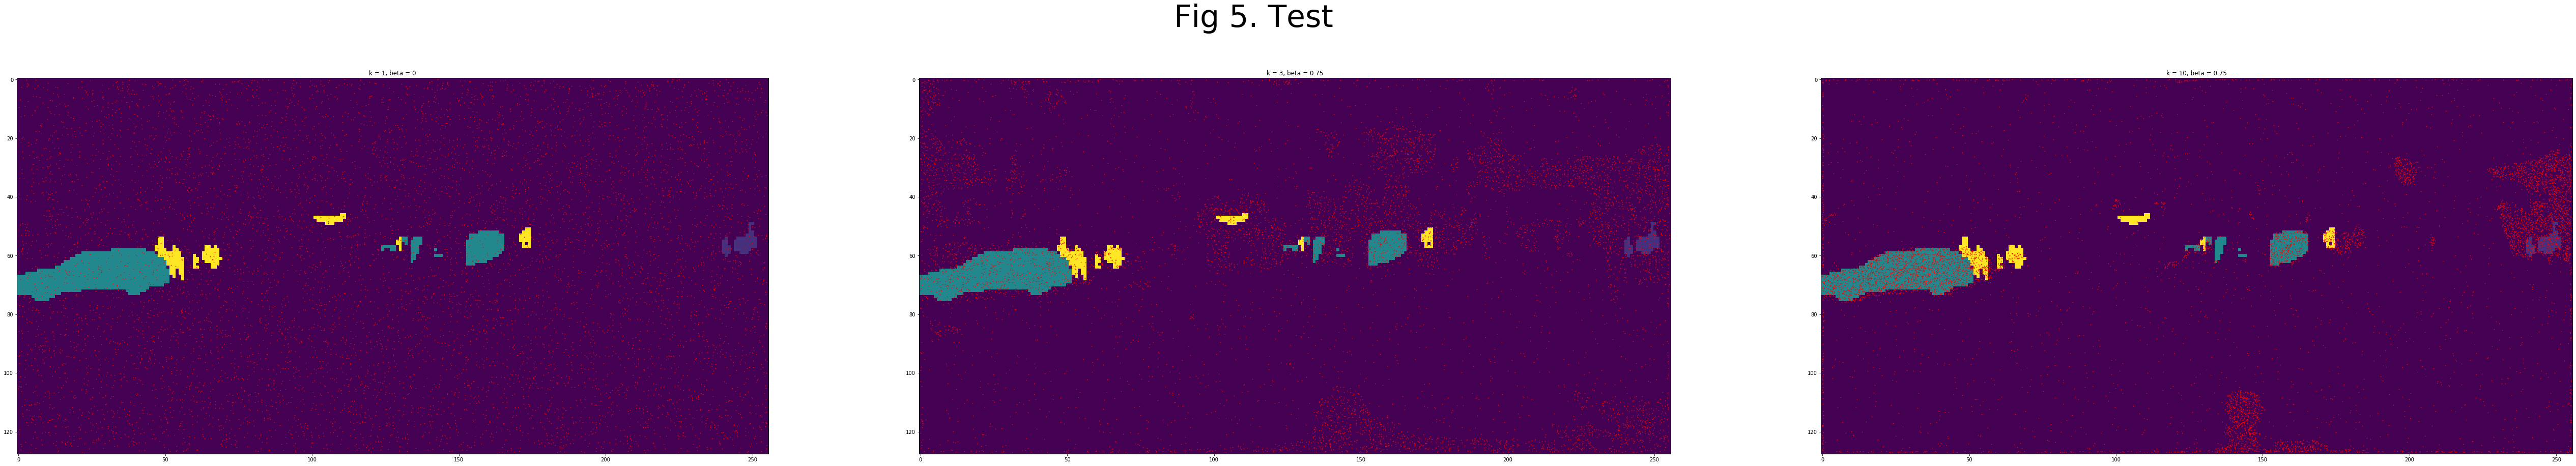

In [9]:
def get_plot_point(k, beta):
    _, _, H, W = out.shape
    points = sampling_points(out, N, k, beta)
    points[:, :, 0] *= W - 1
    points[:, :, 1] *= H - 1
    return points

plot(
    out.softmax(1).argmax(1).float()[0],
    "Fig 5. Test",
     {"k = 1, beta = 0": get_plot_point(1, 0),
      "k = 3, beta = 0.75": get_plot_point(3, 0.75),
      "k = 10, beta = 0.75": get_plot_point(10, 0.75)},
)

# Inference

In [23]:
res2, out

(torch.FloatTensor[1,512,128,256], torch.FloatTensor[1,21,128,256])

In [24]:
out_upscaled = F.interpolate(out, scale_factor=2, mode="bilinear", align_corners=False)
out_upscaled

torch.FloatTensor[1,21,256,512]

In [25]:
uncertainty_map = -1 * (out_upscaled[:, 0] - out_upscaled[:, 1])
uncertainty_map

torch.FloatTensor[1,256,512]

In [26]:
N, H, W = uncertainty_map.shape
h_step = 1 / H
w_step = 1 / W

# mask_point_subdivision_num_points
num_points = (img.shape[-1] // 16) * (img.shape[-2] // 16) 
num_points = min(H * W, num_points)
num_points, h_step, w_step

(8192, 0.00390625, 0.001953125)

In [30]:
# v, idx = torch.topk(uncertainty_map.view(-1, H * W), k=num_points, dim=1)
v, idx = uncertainty_map.view(N, -1).topk(num_points, dim=1)
                                          
# [0, 1] normalized coordinates
points = torch.zeros(N, num_points, 2, dtype=torch.float)
points[:, :, 0] = w_step / 2.0 + (idx % W).to(torch.float) * w_step
points[:, :, 1] = h_step / 2.0 + (idx // W).to(torch.float) * h_step
points, points.min(), points.max()

(torch.FloatTensor[1,8192,2],
 torch.FloatTensor[], 0.0009765625,
 torch.FloatTensor[], 0.9990234375)

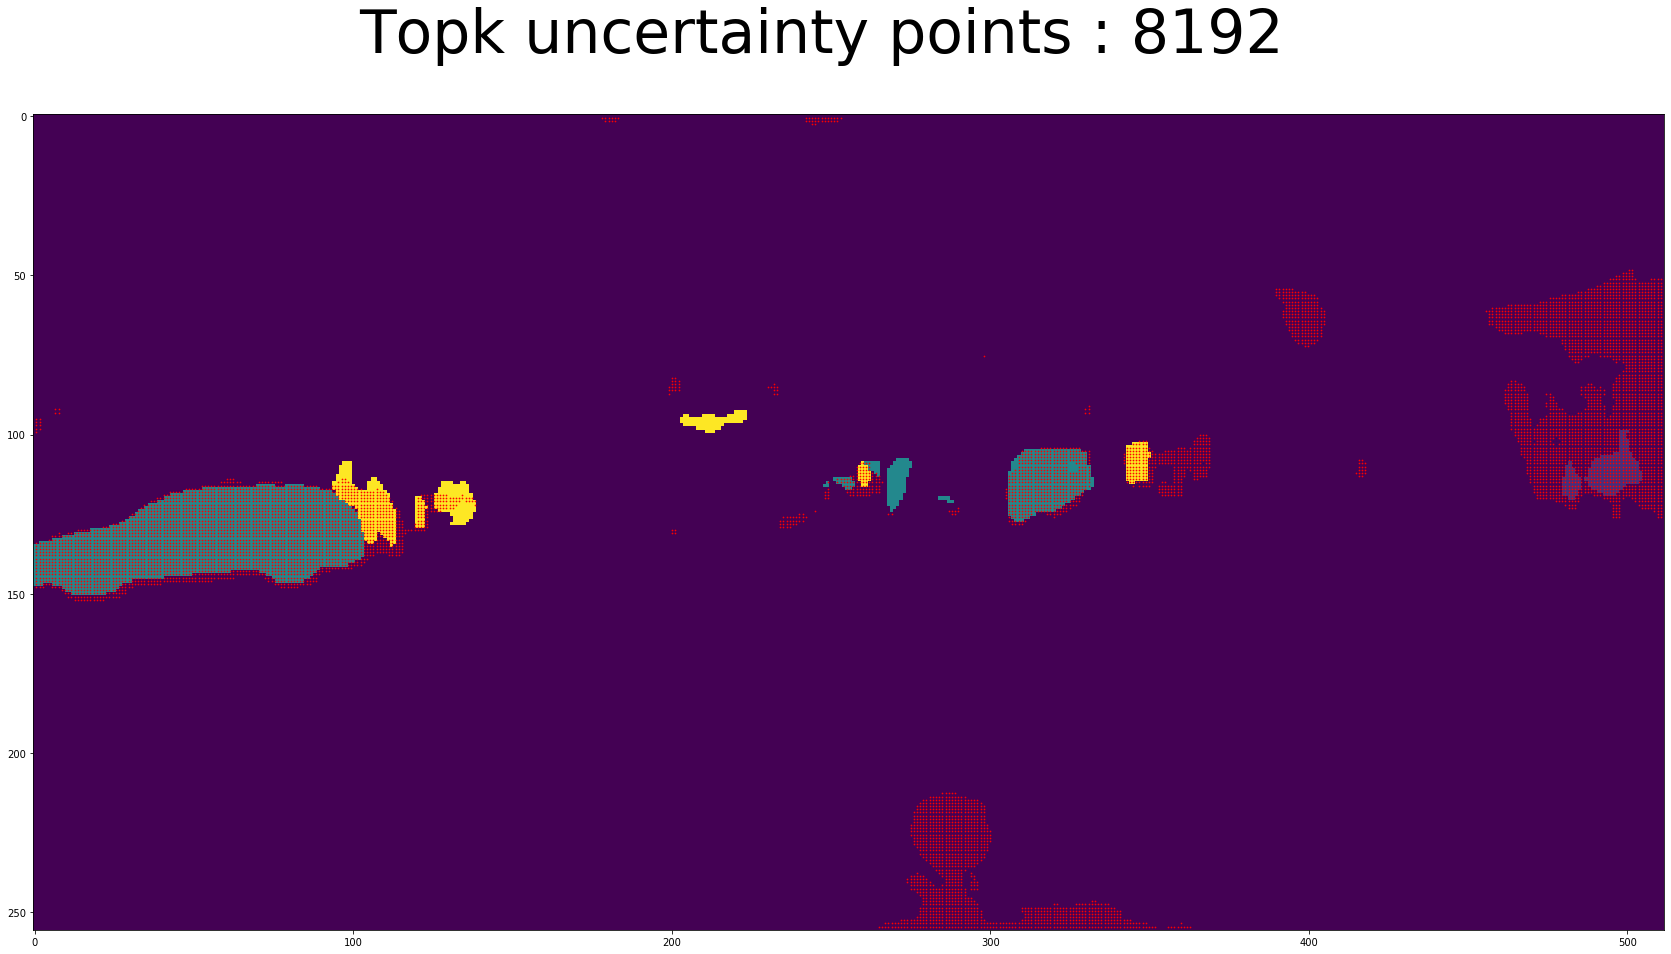

In [31]:
points[:, :, 0] *= W - 1
points[:, :, 1] *= H - 1

plot(
    out_upscaled.softmax(1).argmax(1).float()[0],
    f"Topk uncertainty points : {num_points}",
    {"": points},
)